In [1]:
# 2.1 Import libraries
import math
import os
from six.moves import xrange
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 2.2 Define some constants
# The MNIST dataset has 10 classes, representing the digits 0 through 9
NUM_CLASSES = 10

# The MINST images are always 28x28 pixels
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

# Batch size. Must be evenly dividedable by dataset sizes.
BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

# Number of units in hidden layers
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

# Maximum number of training steps
MAX_STEPS = 2000

# Directory to put the training data.
TRAIN_DIR="/tmp/mnist"

In [3]:
# 2.3 Get input data: get the sets of images and labels for training, validatest test on MNSIT.
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting /tmp/mnist\train-images-idx3-ubyte.gz
Extracting /tmp/mnist\train-labels-idx1-ubyte.gz
Extracting /tmp/mnist\t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist\t10k-labels-idx1-ubyte.gz


In [4]:
# 2.4 Build inference graph.
def mnist_inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Image placeholder
        hidden1_units: Size of the first hidden layer
        hidden2_units: Size of the second hidden layer
    Returns:
        logits: Output tensor with the computed logits
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(tf.truncated_normal(
            [IMAGE_PIXELS, hidden1_units],
            stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))
        ), name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]), name = 'biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights= tf.Variable(tf.truncated_normal(
            [hidden1_units, hidden2_units],
            stddev = 1.0 / math.sqrt(float(hidden1_units))
        ), name = 'weights')
        biases = tf.Variable(tf.zeros([hidden2_units]), name = "biases")
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(tf.truncated_normal(
            [hidden2_units, NUM_CLASSES],
            stddev = 1.0 / math.sqrt(float(hidden2_units))
        ), name = 'weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]), name="biases")
        logits = tf.matmul(hidden2, weights) + biases
        
    return logits

In [9]:
# 2.5 Build training graph
def mnist_training(logits, labels, learning_rate):
    """Build the training graph
    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES]
        labels: Labels tensor, int32 - [BATCH_SIZE], with values int the range [0, NUM_CLASSES)
        learning_rate: The learning rate to use for gradient descent
    Returns:
        train_op: The Op for training.
        loss: The op for calculating loss
    """
    # Create an operation taht calculates loss
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Craete the fradient descent optimzier with the given learning rate
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step
    global_step = tf.Variable(0, name="global_step", trainable = False)
    # Use the optimizer to apply yhe gradients that minimize the loss
    # (and also increment the global step counter) as a single training step
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    #tf.train.write_graph(tf.get_default_graph().as_graph_def(), '/tmp', "train.pbtxt", as_text=True)
    
    return train_op, loss

In [10]:
# 2.6 Build the complete graph for feeding inputs, raining, and saving checkpoints
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels
    images_placeholder = tf.placeholder(tf.float32)
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)
    tf.add_to_collection('labels', labels_placeholder)
    
    # Build a graph taht compute predictions from teh inference model
    logits = mnist_inference(images_placeholder, HIDDEN1_UNITS, HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)
    
    # Add t o the graph thet ops that calculate and apply gradients
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)
    
    # Add the variable initializer op
    init = tf.initialize_all_variables()
    
    # Create a saver for writing training checkpoints
    saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
# 2.7 Run traingin for MAX_STEPS and save checkpoint at the end
with tf.Session(graph=mnist_graph) as sess:
    # Run the op to initialize the variables
    sess.run(init)
    
    # Start the training loop
    for step in xrange(MAX_STEPS):
        # Read a batch of images and labels
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)
        
        # Run one step of the model. The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` op. To
        # inspect the values of your ops or variables, you may include them 
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run(
            [train_op, loss],
            feed_dict = {
                images_placeholder: images_feed,
                labels_placeholder: labels_feed
            }
        )
        
        # Print out loss value
        if step % 100 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))
    
    # Write a checkpoint
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step = step)

Step 0: loss = 2.30
Step 100: loss = 2.18
Step 200: loss = 1.95
Step 300: loss = 1.68
Step 400: loss = 1.38
Step 500: loss = 1.03
Step 600: loss = 0.80
Step 700: loss = 0.72
Step 800: loss = 0.71
Step 900: loss = 0.58
Step 1000: loss = 0.57
Step 1100: loss = 0.67
Step 1200: loss = 0.44
Step 1300: loss = 0.47
Step 1400: loss = 0.62
Step 1500: loss = 0.47
Step 1600: loss = 0.47
Step 1700: loss = 0.47
Step 1800: loss = 0.34
Step 1900: loss = 0.44


INFO:tensorflow:Restoring parameters from /tmp/mnist\checkpoint-1999
Ground true: 8
Prediction: 8


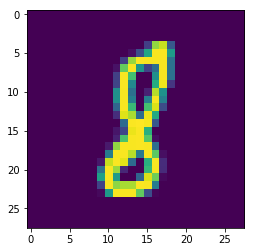

In [15]:
# 2.8 Run evaluation based on the saved checkpoint.
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-1999.meta")
    )
    saver.restore(
        sess, os.path.join(TRAIN_DIR, 'checkpoint-1999')
    )
    
    # Retrieve the ops we remembered
    logits = tf.get_collection('logits')[0]
    images_placeholder = tf.get_collection('images')[0]
    labels_placeholder = tf.get_collection('labels')[0]
    
    # Add an op taht chooses the top k predictions
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation
    images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op, feed_dict = {
        images_placeholder: images_feed,
        labels_placeholder: labels_feed
    })
    print('Ground true: %d\nPrediction: %d' % (labels_feed, prediction.indices[0][0]))